# Predicting stock indices using Long Short Term Memory networks

## Overview

* [Technical indicators](#Technical-indicators)
* [Data setup](#Downloading-cleaning)
* [Basic EDA](#EDA)
* [Model building](#Model-building)
* [Hyperparameter optimization](#Hyperparameter-tuning)
* [Training and vizualizing prediction error](#Training-vizu)
* [Backtesting](#Backtesting)
* [Conclusion](#Conclusion)


### Short introduction

This notebook is a take on using LSTM recurrent neural networks for predicting stock markets in particular European indices. LSTM RNN have shown great success in trying to predict sequence data or timeseries and that is why the framework might be suitable for predicting stock markets. A typical classification problem can either be right or wrong and this is fine when modeling you are just modeling whether something belongs to a class. The issue with stock market predictions is that of course you would like to predict whether the market goes up or down, but also minimize the loss when your prediction is wrong. So the usual evaluation on accuracy is not enough which is were the backtesting becomes important. The model is tested on a index that were not available during training and the true performance is return of investment.  

The data that is used is some of the main indices from Europe but this framework can easily be expanded to include any other index or even be used on individual stock prices. Daily OHLC data from Yahoo Finance is easily accessible. Furthermore the data is enriched with currency exchange rates indices that might have some predictable power on the indices such as EURUSD, EURGBP etc. One of the hypothesis is that a volatility index would also have a predictive power however unfortunately the historical data from VDAX is not available from Yahoo Finance as a proxy we use the VIX, which could a measure of the overall volatility in the global economy and hopefully have some predictive power.

## Packages imports

In [66]:
## Package imports
import os
import datetime

## The usual suspects
import pandas as pd
import numpy as np

## Visualization tools
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

## Packages for downloading financial data
import yfinance as yf

## Neural network tools
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

## Bayesian optimization tools
from bayes_opt import BayesianOptimization
from functools import partial

## Set seed for reproduceability
np.random.seed(1)

In [2]:
## Function to time code.
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

## Technical indicators as features <a class="anchor" id="Technical-indicators">
Technical indicator is widely used by many practitioners (technical analysis) such as Simple Moving Averages (SMA), Bollinger Bands etc. to predict whether the stock is likely to move up or down. We enrich the data with some of the most common technical indicators SMA, Bollinger Bands, RSI, MACD and Fast Fourier Transforms. It can easily incorporate more indicators if needed

In [3]:
## Setup functions for adding features and format data
def macd(data, a, b):
    return data['Close'].ewm(span=a).mean() - data['Close'].ewm(span=b).mean()

def bollinger_bands(data, flag):
    sma = data['Close'].rolling(window=20).mean()
    smv = data['Close'].rolling(window=20).std()
    if flag == 'Upper':
        return sma + 2 * smv
    elif flag == 'Lower':
        return sma - 2 * smv
    else:
        raise ValueError('Wrong input.')
        
def rsi(data):
    df_ret = data['Close'].pct_change()
    g = df_ret * (df_ret > 0)
    l = df_ret * (df_ret < 0)
    avg_g = g.rolling(window=14).mean()
    avg_l = l.rolling(window=14).mean()
    rs = abs(avg_g.divide(avg_l))
    return 100 * rs / (1 + rs)

def fft_indicator(data, k):
    sp = np.fft.fft(data['Close'])
    return abs(np.fft.ifft(sp[:k], len(data)))

def addFeatures(data):
    sma_days = [10,50,100,200]

    for days in sma_days:
        data.loc[:, 'sma' + str(days)] = data['Close'].rolling(window=days).mean()
        data.loc[:, 'ema' + str(days)] = data['Close'].ewm(span=days).mean()

    data.loc[:, 'MACD'] = macd(data, 12, 26)
    data.loc[:, 'BB_Upper'] = bollinger_bands(data, 'Upper')
    data.loc[:, 'BB_Lower'] = bollinger_bands(data, 'Lower')
    data.loc[:, 'RSI'] = rsi(data)
    
    data.dropna(inplace=True)
    
    data.loc[:, 'fft3'] = fft_indicator(data,3)
    data.loc[:, 'fft6'] = fft_indicator(data,6)
    data.loc[:, 'fft9'] = fft_indicator(data,9)
    
    return data

def nnFormat(data, window=4):
    nrows = data.shape[0]
    ncols = data.shape[1]

    features = np.zeros(shape=(0, window, ncols - 2))
    label1 = np.zeros(shape=(0,1))
    label2 = np.zeros(shape=(0,1))
    
    for i in range(window,nrows-1):
        features = np.append(features, data.iloc[i-window:i,0:(ncols-2)].to_numpy().reshape(1, window, ncols - 2), axis=0)
        label1 = np.append(label1, data.iloc[i, ncols-2].reshape(1,1), axis=0)
        label2 = np.append(label2, data.iloc[i, ncols-1].reshape(1,1), axis=0)
    
    
    return features, label1, label2

## Downloading and cleaning data <a class="anchor" id="Downloading-cleaning">

In [4]:
startDate = '2007-01-02'

## Download currency data + VIX
curr_vix_list = ['EURUSD=X', 'EURGBP=X', 'EURSEK=X', 'EURJPY=X', 'EURCNY=X', '^VIX']
curr_vix_data = yf.download(curr_vix_list, start=startDate)
curr_vix_data = curr_vix_data['Close']
curr_vix_data = curr_vix_data.rename(columns={"EURUSD=X": "EURUSD", 
                                      "EURGBP=X": "EURGBP", 
                                      "EURSEK=X": "EURSEK", 
                                      "EURJPY=X": "EURJPY",
                                      "EURCNY=X": "EURCNY"})

indices = ['^STOXX50E', '^N100', '^BFX', '^GDAXI', '^FTSE', '^FCHI']

sequence_length = 20
features = np.zeros(shape=(0, sequence_length, 25))
label1 = np.zeros(shape=(0,1))
label2 = np.zeros(shape=(0,1))

for ind in indices:
    print(ind)
    data = yf.download(ind, start=startDate)
    data = pd.concat([data, curr_vix_data], axis=1)
    data.fillna(method='ffill', inplace=True)
    data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
    data = addFeatures(data)
    
    data.loc[:, 'Gradient'] = ((data.loc[:, 'Close'] - data.loc[:, 'Close'].shift())/data.loc[:, 'Close'].shift() + 1).shift(-1)
    data.dropna(inplace=True)
    buySell = data.loc[:, 'Gradient'] > 1 
    
    ## Normalizing data
    norm_data = (data - data.min())/(data.max() - data.min())
    norm_data.loc[:, 'BuySell'] = buySell.astype(int)
    
    tempFeatures, tempLabel1, tempLabel2 = nnFormat(norm_data,sequence_length)
    
    features = np.append(features, tempFeatures, axis=0)
    label1 = np.append(label1, tempLabel1, axis=0)
    label2 = np.append(label2, tempLabel2, axis=0)

[*********************100%***********************]  6 of 6 completed
^STOXX50E
[*********************100%***********************]  1 of 1 completed
^N100
[*********************100%***********************]  1 of 1 completed
^BFX
[*********************100%***********************]  1 of 1 completed
^GDAXI
[*********************100%***********************]  1 of 1 completed
^FTSE
[*********************100%***********************]  1 of 1 completed
^FCHI
[*********************100%***********************]  1 of 1 completed


## Basic EDA <a class="anchor" id="EDA">

Just to get a quick feel of how the data behaves we take a look at the German index DAX and the features that is added to the data.

In [5]:
data = yf.download('^GDAXI', start=startDate, progress=False)
data = pd.concat([data, curr_vix_data], axis=1)
data.fillna(method='ffill', inplace=True)
data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
data = addFeatures(data)

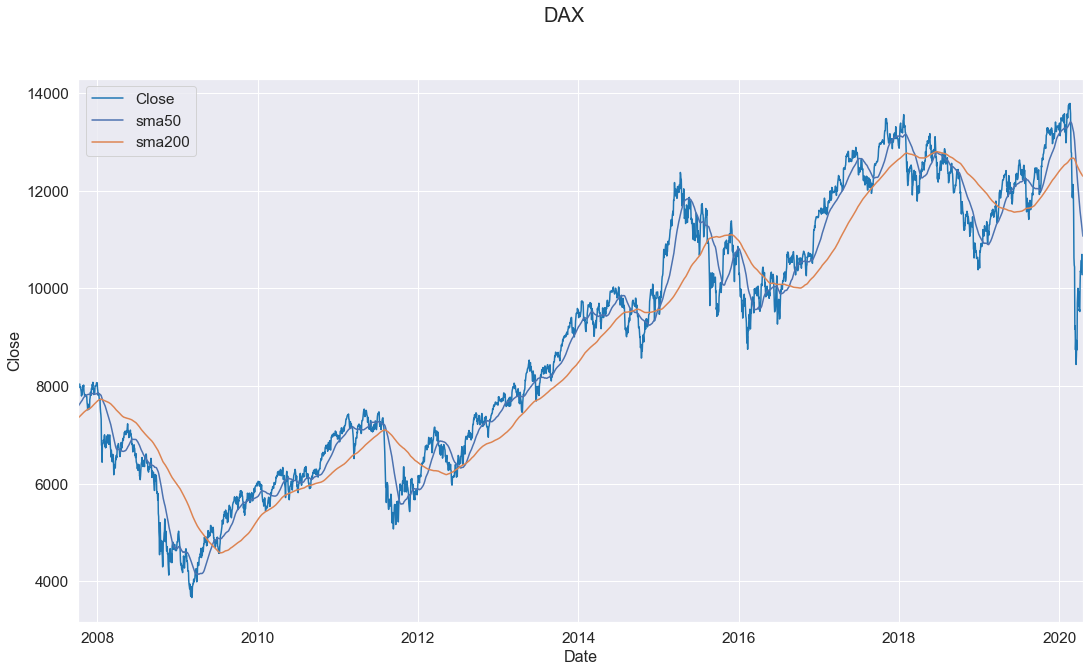

In [67]:
## Plot closing prices
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
fig.suptitle('DAX', fontsize=20)
ax.set_ylabel('Close', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax = data['Close'].plot(color=(31/255,119/255,180/255))
ax = data['sma50'].plot()
ax = data['sma200'].plot()
ax.legend();

Data since 2007-01-01 is included to have the latest financial crisis in the data and the reason for not taking all data available is that you could argue that algorithmic trading have gone up significantly over the last couple of years and have changed the way stocks and indices are being traded. This is what one would like to capture in a model and not how stocks were traded let's say 20 years ago.

Two of the most common indicators (sma50 and sma200) have been depicted along side the historical and many more have been added as features. 6 different indicators is used in this model but with different parameters making it so that total of 15 extra features are added to the OHLC data.  

Next lets take a look at the correlation between the features in the model.

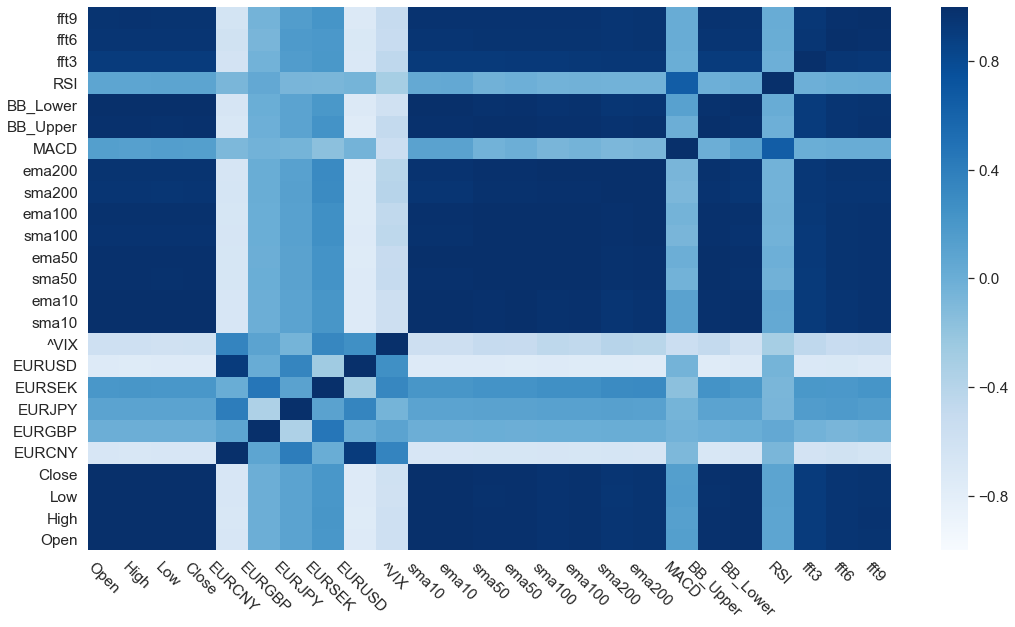

In [68]:
## Correlation plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
sn.heatmap(data.corr(), cmap='Blues', ax=ax, vmin=-1, vmax=1)
ax.tick_params(axis='x', rotation=-45)
ax.invert_yaxis()

The correlation is set between -1 to 1 where 1 corresponds with perfect positive correlation i.e. if the close price goes up the feature also goes up in the similar fashion and -1 is then given by the opposite. As we would expect some of the simple features that is based on the close price have a close correlation with the close price. Remember the task is basically to predict the next close price. 

## Train-Val-Test-Split

The split is done randomly from the dataset. So that every 20 length sequence with corresponding label is a independent observation. This however can be a problem when we look at the generalization error as the the model have been exposed to data points around the test set that is shared for training examples and test example because the each data point consist of a sequence of 20 days. You could instead base the validation set and training set on the dates such that newer data is the validation and test set respectively. The last section in this notebook a backtesting with an index that the model never has seen before is performed to see how well the model performs in terms of return.

In [8]:
## Splitting data into training, validation and test sets
index = np.random.permutation(features.shape[0])

training_idx, validation_idx, test_idx = index[:int(features.shape[0]*0.8)], index[int(features.shape[0]*0.8):int(features.shape[0]*0.95)], index[int(features.shape[0]*0.95):]
train_features, validation_features, test_features = features[training_idx,:], features[validation_idx,:], features[test_idx,:]
train_label1, validation_label1, test_label1 = label1[training_idx,:], label1[validation_idx,:], label1[test_idx,:]
train_label2, validation_label2, test_label2 = label2[training_idx,:], label2[validation_idx,:], label2[test_idx,:]

## Model building <a class="anchor" id="Model-building">
    
Different layouts for the model have been tried ending with a dual output LSTM model. The main idea of this model is to predict whether the index goes up or down the following period the intuitive way is to see this only as a classification problem but some problems may arise from this. If model is solely based on classification it is not penalized how far the model is from the actual change. This can result in that when the model makes a wrong prediction the loss can much higher than gain when the prediction is on point and the model is only evaluated on how if the price goes up or down. Which is why the model is built such that it also tries to predict the change in the index. Giving us a model that both minimizes the binary crossentropy on the classification problem and a mean squared error on prediction of the change in the index.
    
One thing to be aware of when using LSTM is that the gradient can explode which is why clipping the gradient is used. Here we use keras implementation with the clipnorm. As a regularizer we use the simple dropout technique and treat learning rate, clipnorm, batch size and dropout rate as hyperparameters to be optimized. For the dense layer just before the sigmoid layer the scaled exponential linear unit is used. 

In [9]:
## Model building
def get_model(input_shape, 
              lstm_layer_1_nodes,
              lstm_layer_2_nodes,
              dense_layer_nodes,
              dropout_rate):
    
    input_layer = Input(shape=input_shape, name='Input_Layer')
    
    lstm_layer_1 = LSTM(lstm_layer_1_nodes, 
                        dropout = dropout_rate, 
                        return_sequences=True, 
                        name='First_LSTM_Layer')(input_layer)
    
    lstm_layer_2 = LSTM(lstm_layer_2_nodes, 
                        dropout = dropout_rate,
                        name='Second_LSTM_Layer')(lstm_layer_1)
    
    dense_layer_1 = Dense(dense_layer_nodes, 
                          activation='selu', 
                          name='First_Dense_Layer')(lstm_layer_2)
    
    dropout_layer_1 = Dropout(dropout_rate, 
                              name='First_Dropout_Layer')(dense_layer_1)
    
    output_layer_1 = Dense(1,
                          activation=None,
                          name='Gradient_Prediction')(lstm_layer_2)
    
    output_layer_2 = Dense(1,
                          activation='sigmoid',
                          name='BuySell_Prediction')(dropout_layer_1)

    lstm_model = Model(input_layer, [output_layer_1, output_layer_2])
    
    
    return lstm_model

def fit_model(input_shape,
              dropout_rate,
              lr,
              batch_size,
              clipnorm):
    
    lstm_layer_1_nodes = 75
    lstm_layer_2_nodes = 75
    dense_layer_nodes = 50

    lstm_model = get_model(input_shape, 
                           int(lstm_layer_1_nodes),
                           int(lstm_layer_2_nodes),
                           int(dense_layer_nodes),
                           dropout_rate)
    
    opt = Adam(lr=lr, clipnorm=clipnorm)
    
    loss = {
    'Gradient_Prediction': 'mean_squared_error',
    'BuySell_Prediction': 'binary_crossentropy'
    }

    metrics = {
        'BuySell_Prediction': 'accuracy'
    }

    lstm_model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    
    mcp = ModelCheckpoint(checkpoint_path, 
                          monitor='val_BuySell_Prediction_accuracy', 
                          mode='max', 
                          save_best_only=True,
                          save_weights_only=True)
    
    lstm_model.fit(train_features, [train_label1, train_label2],
                   epochs=50,
                   batch_size=int(batch_size),
                   validation_data = [validation_features, {'Gradient_Prediction': validation_label1,
                                                                                'BuySell_Prediction': validation_label2}],
                   callbacks=[mcp],
                   verbose=0)
    
    lstm_model.load_weights('baysianOpt/cp.ckpt')
    
    score = lstm_model.evaluate(validation_features, [validation_label1, validation_label2], verbose=0)

    return score[3]

## Hyperparameter tuning <a class="anchor" id="Hyperparameter-tuning">
    
As stated above the parameters for tuning is the learning rate, clipnorm, batch size and dropout rate. For this an implementation of baysian optimization is used. The baysian optimization makes the tuning of the hyperparameter into a new optimization problem meaning that hopefully the model does not have to go through to many iterations before a set of optimal or near optimal hyperparameters can be chosen to fully train the model. Because of the computational power it takes to fully train the neural network the baysian optimization is done on 50 epochs with early stopping.  This is done because the computational power of the device the notebook is developed on is not ideal for a setup like this. Evaluating the performance of the model on the accuracy. Need to check whether the accuracy is better if the combined losses is used instead.

In [10]:
## Baysian optimization

checkpoint_path = 'baysianOpt/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

fit_model_partial = partial(fit_model, (features.shape[1], features.shape[2]))

tic()
pbounds = {'dropout_rate': (0.1, 0.35), 
           'lr': (1e-5, 1e-2),
           'batch_size':(128,256),
           'clipnorm':(0.5,1.5)}

optimizer = BayesianOptimization(
    f=fit_model_partial,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=5, n_iter=20)

baysianOptimum = optimizer.max

toc()

|   iter    |  target   | batch_... | clipnorm  | dropou... |    lr     |
-------------------------------------------------------------------------
|  1        |  0.5304   |  181.4    |  1.22     |  0.1      |  0.00303  |
|  2        |  0.5324   |  146.8    |  0.5923   |  0.1466   |  0.003462 |
|  3        |  0.5256   |  178.8    |  1.039    |  0.2048   |  0.006855 |
|  4        |  0.5307   |  154.2    |  1.378    |  0.1068   |  0.006708 |
|  5        |  0.5342   |  181.4    |  1.059    |  0.1351   |  0.001989 |
|  6        |  0.5396   |  256.0    |  0.5      |  0.1287   |  0.003365 |
|  7        |  0.5245   |  225.1    |  0.5316   |  0.32     |  0.006916 |
|  8        |  0.5208   |  128.1    |  1.459    |  0.2792   |  0.009179 |
|  9        |  0.5314   |  202.1    |  0.52     |  0.3359   |  0.002766 |
|  10       |  0.5314   |  243.6    |  1.453    |  0.1371   |  0.003628 |
|  11       |  0.5362   |  256.0    |  1.496    |  0.3452   |  0.002052 |
|  12       |  0.5297   |  194.4    | 

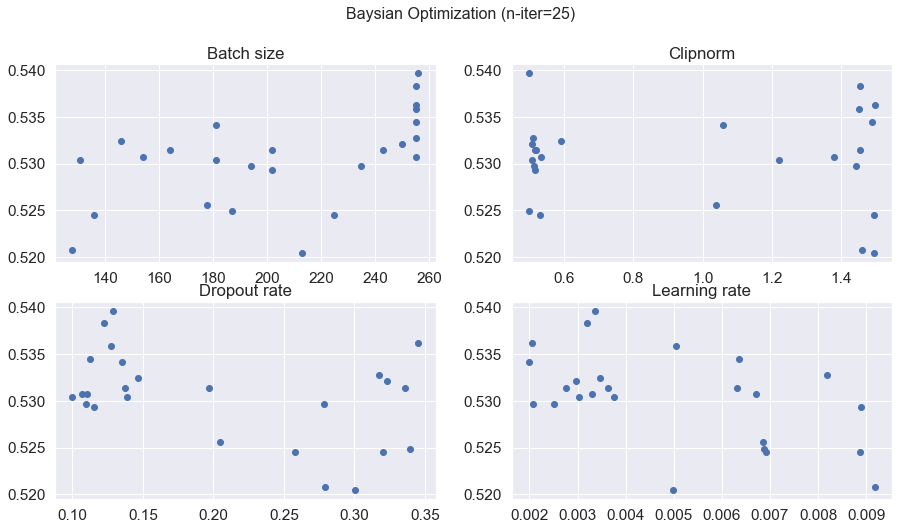

In [69]:
accuracy_list = [i['target'] for i in optimizer.res]
batch_size_list = [int(i['params']['batch_size']) for i in optimizer.res]
clipnorm_list = [i['params']['clipnorm'] for i in optimizer.res]
dropout_rate_list = [i['params']['dropout_rate'] for i in optimizer.res]
lr_list = [i['params']['lr'] for i in optimizer.res]


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
fig.suptitle('Baysian Optimization (n-iter=25)', fontsize=16)

ax[0][0].scatter(batch_size_list, accuracy_list)
ax[0][0].set_title("Batch size")

ax[0][1].scatter(clipnorm_list, accuracy_list)
ax[0][1].set_title('Clipnorm')

ax[1][0].scatter(dropout_rate_list, accuracy_list)
ax[1][0].set_title('Dropout rate')

ax[1][1].scatter(lr_list, accuracy_list)
ax[1][1].set_title('Learning rate');


It is unclear whether the baysian optimization actually learned something, and we maybe should have used random search instead, which can be even more computationally heavy (this would quickly become infeasible with the current device this notebook is running on). For now we set the hyperparameters from the baysian optimization and try to do the full training. 

In [12]:
input_shape = (features.shape[1], features.shape[2])
lstm_layer_1_nodes = 75
lstm_layer_2_nodes = 75
dense_layer_nodes = 50

useBayesian = True 

if useBayesian:
    dropout_rate = baysianOptimum['params']['dropout_rate']
    batch_size = int(baysianOptimum['params']['batch_size'])
    clipnorm = baysianOptimum['params']['clipnorm']
    lr = baysianOptimum['params']['lr']
else:
    dropout_rate = 0.1
    batch_size = 229
    clipnorm = 1.5
    lr = 0.003088

lstm_model = get_model(input_shape, 
              lstm_layer_1_nodes,
              lstm_layer_2_nodes,
              dense_layer_nodes,
              dropout_rate)

opt = Adam(lr=lr, clipnorm=clipnorm)

loss = {
    'Gradient_Prediction': 'mean_squared_error',
    'BuySell_Prediction': 'binary_crossentropy'
}

metrics = {
    'BuySell_Prediction': 'accuracy'
}
lstm_model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)

lstm_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 20, 25)]     0                                            
__________________________________________________________________________________________________
First_LSTM_Layer (LSTM)         (None, 20, 75)       30300       Input_Layer[0][0]                
__________________________________________________________________________________________________
Second_LSTM_Layer (LSTM)        (None, 75)           45300       First_LSTM_Layer[0][0]           
__________________________________________________________________________________________________
First_Dense_Layer (Dense)       (None, 50)           3800        Second_LSTM_Layer[0][0]          
___________________________________________________________________________________________

## Model training  <a class="anchor" id="Training-vizu">
    
For model training we use the parameters from the baysian optimization and it seems that the model converges after aprox. 1000 epochs. During training we make checkpoints based on the accuracy making sure that we save the weights corresponding with the best performing model based on accuracy on the validation set (early stopping). This is done especially because the loss function is volatile but also to make it so that going forward we are sure to use the best model that were achieved through training.

In [13]:
## Setup Checkpoints for early stopping
checkpoint_path = 'twoOutputCheckpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

mcp = ModelCheckpoint(checkpoint_path, 
                          monitor='val_BuySell_Prediction_accuracy', 
                          mode='max', 
                          save_best_only=True,
                          save_weights_only=True)

tic()
model_history = lstm_model.fit(train_features, 
                               {'Gradient_Prediction': train_label1,
                                'BuySell_Prediction': train_label2},
                               epochs=1000,
                               validation_data = [validation_features, {'Gradient_Prediction': validation_label1,
                                                                        'BuySell_Prediction': validation_label2}],
                               batch_size=batch_size,
                               callbacks=[mcp],
                               verbose=0
                              )
toc()

## Visualization of training step

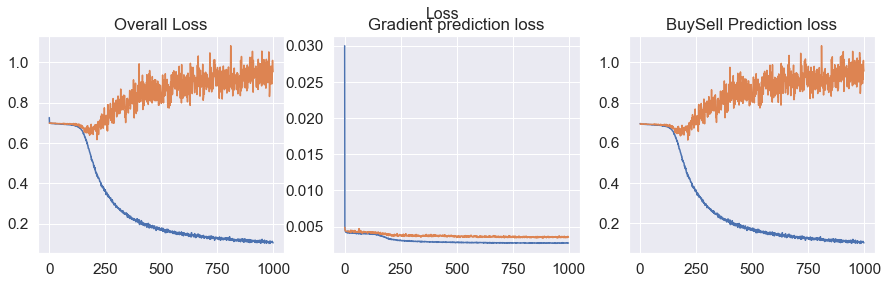

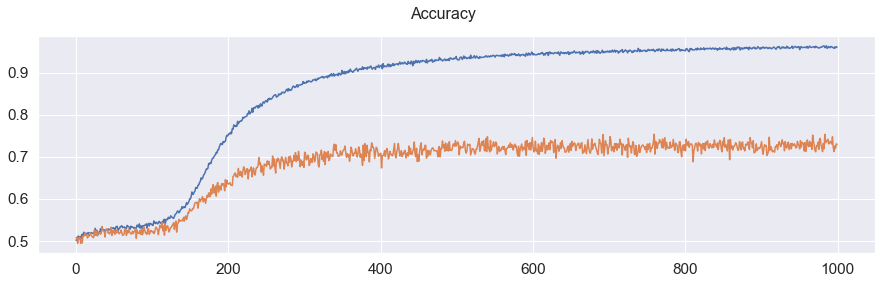

In [70]:
## Loss plots
lossfig, lossaxes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

lossfig.suptitle('Loss', fontsize=16)

lossaxes[0].plot(model_history.history['loss'], label='Training')
lossaxes[0].plot(model_history.history['val_loss'], label='Validation')
lossaxes[0].set_title('Overall Loss')

lossaxes[1].plot(model_history.history['Gradient_Prediction_loss'], label='Training')
lossaxes[1].plot(model_history.history['val_Gradient_Prediction_loss'], label='Validation')
lossaxes[1].set_title('Gradient prediction loss')

lossaxes[2].plot(model_history.history['BuySell_Prediction_loss'], label='Training')
lossaxes[2].plot(model_history.history['val_BuySell_Prediction_loss'], label='Validation')
lossaxes[2].set_title('BuySell Prediction loss')

## Accuracy plot
accfig, accaxes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

accfig.suptitle('Accuracy', fontsize=16)

accaxes.plot(model_history.history['BuySell_Prediction_accuracy'], label='Training')
accaxes.plot(model_history.history['val_BuySell_Prediction_accuracy'], label='Training');

The model achieve quite high accuracy on the validation training set however looking at the classification loss there seem to be some kind of overfitting going on. One could argue that the error term on the change of the price is not weighing enough on the full loss function and it could be interesting to see the performance if this where changed. The best weights is saved, based on accuracy and for the rest of the notebook it is those weights that will be used.

## Evaluating test data <a class="anchor" id="Test-eval">

To visualize how well the model generalizes we look at the test data.

972/972 [==============================] - 2s 2ms/sample - loss: 0.7908 - Gradient_Prediction_loss: 0.0034 - BuySell_Prediction_loss: 0.7821 - BuySell_Prediction_accuracy: 0.7665


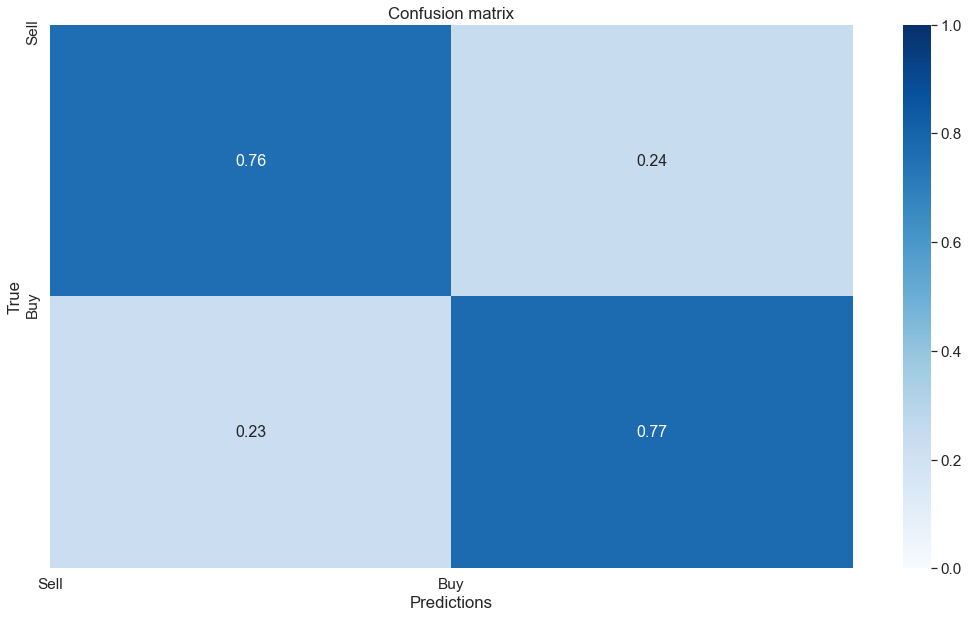

In [71]:
lstm_model.load_weights('twoOutputCheckpoints/cp.ckpt')
lstm_model.evaluate(test_features, [test_label1, test_label2])
prediction = lstm_model.predict(test_features)

## Confusion matrix
conf_mat = confusion_matrix(test_label2, (prediction[1] > 0.5), normalize = 'true')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, ax=ax, annot=True, annot_kws={"size": 16}, cmap='Blues', vmin=0, vmax=1) # font size
plt.xticks(ticks=np.arange(2), labels=['Sell', 'Buy'])
plt.yticks(ticks=np.arange(2), labels=['Sell', 'Buy'])
plt.xlabel('Predictions')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

As seen by the confusion matrix the model performs quite good on the test data. Most interesting is actually the false positive and the false negative as this would be were the model looses money. You can see that when the index goes up only 23% of the times the model does not classify correctly and in 77% of the cases it is on the money. If you rely only on a strategy were you go long the false positive (the top right) is what you want to minimize. And if you rely on a strategy were it is possible to go both long and short you will have to take both false negatives and false positives into account. So hopefully when the model classifies correctly the return will out weigh the negative return the occurs when the classification is off. To investigate this further a backtesting of a index the model have not seen were performed.

## Backtesting <a class="anchor" id="Backtesting">
To see how the model performs in "real" life data from a index that the model has never seen is pulled from yahoo finance. In this case OMX30 (Stockholm) to actually see if the model has a positive return. 3 different strategies is benchmarked against each other.

* Passive - Buy and hold strategy.
* Long only - The model is only allowed to go long in the asset.
* Long and short - The model is allowed to go both long and short in the asset.
    
Trading costs is not considered in this backtest which is a relevant factor especially when the trading frequency possibly could be daily. The passive strategy is considered as the benchmark for the model, i.e. what is the return of the indec if you passively invested in the index if doing this by ETF's or another product there would also be some recurring cost by just owning this product. These cost is not considered either. 

In [64]:
## Backtrading
backtestIndex = yf.download('^OMX', start=startDate)
backtestIndex = pd.concat([backtestIndex, curr_vix_data], axis=1)
backtestIndex.fillna(method='ffill', inplace=True)
backtestIndex.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
backtestIndex = addFeatures(backtestIndex)

backtestIndex.loc[:, 'Gradient'] = ((backtestIndex.loc[:, 'Close'] - backtestIndex.loc[:, 'Close'].shift())/backtestIndex.loc[:, 'Close'].shift() + 1).shift(-1)
backtestIndex.dropna(inplace=True)
buySell = backtestIndex.loc[:, 'Gradient'] > 1 

## Normalizing data
norm_backtestIndex = (backtestIndex - backtestIndex.min())/(backtestIndex.max() - backtestIndex.min())
norm_backtestIndex.loc[:, 'BuySell'] = buySell.astype(int)

backtestIndexFeatures, backtestIndexLabel1, backtestIndexLabel2 = nnFormat(norm_backtestIndex,sequence_length)

lstm_model.evaluate(backtestIndexFeatures, [backtestIndexLabel1, backtestIndexLabel2]);

[*********************100%***********************]  1 of 1 completed
2756/2756 [==============================] - 1s 329us/sample - loss: 1.3566 - Gradient_Prediction_loss: 0.0085 - BuySell_Prediction_loss: 1.3551 - BuySell_Prediction_accuracy: 0.5943


The model achieves an accuracy of just around 60% which is far lower than the around the 75% accuracy in the test set. The decrease in accuracy can be explained by a number of things e.g the model has never seen any data from the OMX 30 or that the issues discussed with how the validation/test data were chosen actually had an impact. However in the stock market an accuracy of 60 % is not bad at all depending of course on how much you loose when the prediction is wrong.

Lets take a look at how the model actually performs in terms of return.

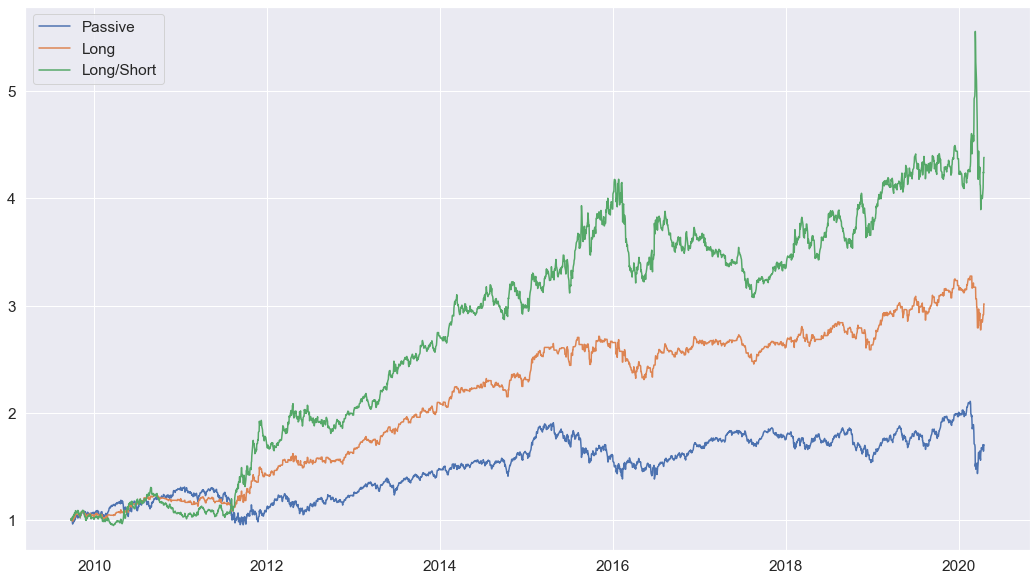

In [65]:
backtradePredict = lstm_model.predict(backtestIndexFeatures)[1] > 0.5
closePrice = backtestIndex.iloc[backtestIndex.shape[0]-backtradePredict.shape[0]:, 25]
closePrice = pd.DataFrame(closePrice)
closePrice.loc[:, 'Prediction'] = backtradePredict
closePrice.loc[:, 'BuySell'] = (closePrice.loc[:,'Prediction']==False).astype(int) * -1 + closePrice.loc[:,'Prediction'].astype(int)
closePrice['LongStrat'] = ((closePrice['Gradient'] - 1) * closePrice['Prediction'] + 1).cumprod()
closePrice['LongShortStrat'] = ((closePrice['Gradient'] - 1) * closePrice['BuySell'] + 1).cumprod()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

ax = plt.plot(closePrice['Gradient'].cumprod(), label='Passive')
ax = plt.plot(closePrice['LongStrat'], label='Long')
ax = plt.plot(closePrice['LongShortStrat'], label='Long/Short')
plt.legend();

The graph above shows that the short and long strategy outperforms the passive strategy for the most part. For the first half a year the model there is not that big of a difference, but as time goes on both the long strategy and the long/short strategy increases the gap to the passive strategy. The passive strategy would have resulted in a 70.2% increase compared to 306.9% and 453.8% of the only long and long/short respectively.

## Conclusion <a class="anchor" id="Conclusion">
So to sum up the well known sequence neural network that is LSTM have shown to be rather well to predict how the stock market moves. During training one could argue that the model seems to overfit based on validation set but nevertheless the accuracy on the test set still in the range of the validation set. And the backtesting of the model with an index that were not used in the training section could argue that the model does indeed learn something that can be used for earning money in the stock market.

It would be possible to set up this as automated trading algorithm if your broker has somekind of API connection and in that case it would perhaps be interesting to look at this model with high frequency data, such as 1m ticks some similar, to see if it will also perform as well in intra day trading.
    
Next steps in improving this model would be to look into the overfitting during training. This could be achieved by increasing the epochs during hyperparameter search because as it is now the overfitting happens in range where the hyperparameter search never reaches. 